In [1]:
import numpy as np
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import matplotlib.pyplot as plt
import matplotlib.ticker
import math
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': print(torch.cuda.get_device_name()) 

cpu


# Data Prep

Training and Testing data is prepared from the solution file

In [2]:
n = 128
x_1 = np.linspace(-1, 1, 2*n+1)
y_1 = np.linspace(1, 0, n+1)
Y_1, X_1 = np.meshgrid(y_1, x_1)
x_2 = np.linspace(-1, 0, n+1)
y_2 = np.linspace(-1/n, -1, n)
Y_2, X_2 = np.meshgrid(y_2, x_2)

x = np.vstack((X_1.flatten(order='F')[:, None], X_2.flatten(order='F')[:, None]))
y = np.vstack((Y_1.flatten(order='F')[:, None], Y_2.flatten(order='F')[:, None]))

# Test Data

We prepare the test data to compare against the solution produced by the PINN.

In [3]:
X_v_test = np.hstack((x, y))
v_true = x*y*(math.e**(x**2-1)-1)*(math.e**(y**2-1)-1)
r = np.sqrt(x**2 + y**2)
theta = np.arctan2(y, x)
theta = np.where(theta < 0, theta + 2*np.pi, theta)
sd = r**(2/3) * np.sin(2*theta/3)
R = 1/2
etad = np.where(r < R, 15 / 16 * (
                    8 / 15 - (4 * r / R - 3) + 2 / 3 * (4 * r / R - 3) ** 3 - 1 / 5 * (4 * r / R - 3) ** 5), 0)
etad = np.where(r < R/2, 1, etad)
u_true = v_true + math.e**(-np.pi*r)* sd * etad

lb = np.array([-1, -1]) #lower bound
ub = np.array([1, 1])  #upper bound

# Training Data

In [4]:
def trainingdata(N_v,N_f):
    
    edge1_x = np.hstack((np.linspace(-1, 1, 2*n+1)[:, None], np.linspace(1, 1, 2*n+1)[:, None]))
    edge2_x = np.hstack((np.linspace(1, 1, n+1)[:, None], np.linspace(1, 0, n+1)[:, None]))
    edge3_x = np.hstack((np.linspace(1, 0, n+1)[:, None], np.linspace(0, 0, n+1)[:, None]))
    edge4_x = np.hstack((np.linspace(0, 0, n+1)[:, None], np.linspace(0, -1, n+1)[:, None]))
    edge5_x = np.hstack((np.linspace(0, -1, n+1)[:, None], np.linspace(-1, -1, n+1)[:, None]))
    edge6_x = np.hstack((np.linspace(-1, -1, 2*n+1)[:, None], np.linspace(-1, 1, 2*n+1)[:, None]))

    all_X_v_train = np.vstack([edge1_x, edge2_x, edge3_x, edge4_x, edge5_x, edge6_x])

    # choose random N_v points for training
    all_X_v_train_r = np.sqrt(all_X_v_train[:, 0]**2 + all_X_v_train[:, 1]**2)
    probability = np.where(all_X_v_train_r == 0, 0, 1)
    probability = probability / np.sum(probability)
    idx = np.random.choice(all_X_v_train.shape[0], N_v, replace=False, p=probability)
    X_v_train = all_X_v_train[idx[0:N_v], :]  # choose indices from  set 'idx' (x,t)
    
    '''Collocation Points'''

    # N_f sets of tuples(x,t)
#     probability = np.where(r == 0, 0, 1)
#     probability = probability / np.sum(probability)
#     idx = np.random.choice(X_v_test.shape[0], N_f, replace=False, p=probability.T[0])
#     X_f = X_v_test[idx[0:N_f], :]
    
    prob = np.where(np.random.rand(1, N_f) < 2/3, 1 , 0)
    N = np.sum(prob)

    lb = np.array([-1, -1])
    ub = np.array([0, 1])
    X_f_1 = lb + (ub - lb) * lhs(2, N)
    lb = np.array([0, 0])
    ub = np.array([1, 1])
    X_f_2 = lb + (ub - lb) * lhs(2, N_f - N)
    X_f = np.vstack((X_f_1, X_f_2))

    X_f_train = np.vstack((X_f, X_v_train))  # append training points to collocation points

    return X_f_train, X_v_train

# SEPINN

Creating sequential layers using the class
tf.Module

In [5]:
class Sequentialmodel(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()

        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
    
        'Initialise neural network as a nn.MSELosslist using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
        # Parameter
        #self.lambdah = torch.nn.Parameter(0.8*torch.ones(1).to(device),requires_grad=True)
        self.lambdah = torch.autograd.Variable(0.8*torch.ones(1).to(device),requires_grad=True)
        
        'Xavier Normal Initialization'
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers)-1):
            
            # weights from a normal distribution with 
            # Recommended gain value for tanh = 5/3?
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)
            

    def forward(self,x):
        
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub).float().to(device)
        l_b = torch.from_numpy(lb).float().to(device)
                      
        #preprocessing input 
        x = (x - l_b)/(u_b - l_b) #feature scaling
        
        #convert to float
        a = x.float()
        
        for i in range(len(layers)-2):
            
            z = self.linears[i](a)
                        
            a = self.activation(z)
            
        a = self.linears[-1](a)
        
        return a
                        
    def loss_BC(self,x,y):
                
        loss_v = self.loss_function(self.forward(x), y)
                
        return loss_v
    
    def loss_PDE(self, x_to_train_f):
                
        x_1_f = x_to_train_f[:,[0]]
        x_2_f = x_to_train_f[:,[1]]
                        
        g = x_to_train_f.clone()
                        
        g.requires_grad = True
        
        vv = self.forward(g)
                
        v_x = autograd.grad(vv,g,torch.ones([x_to_train_f.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
        v_xx = autograd.grad(v_x[:,[0]],g,torch.ones([x_to_train_f.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
        v_yy = autograd.grad(v_x[:,[1]],g,torch.ones([x_to_train_f.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
        v_xx_1 = v_xx[:,[0]]
        v_xx_2 = v_yy[:,[1]]
                        
        r = torch.sqrt(x_1_f ** 2 + x_2_f ** 2)
        theta = np.arctan2(x_2_f, x_1_f)
        theta = torch.where(theta < 0, theta + 2 * np.pi, theta)
        eta = torch.where(r < R, 15 / 16 * (8 / 15 - (8 * r - 3) + 2 / 3 * (8 * r - 3) ** 3 - 1 / 5 * (8 * r - 3) ** 5), 0)
        eta = torch.where(r < R/2, 1, eta)
        p = math.e**(-np.pi*r) * r**(2/3) * np.sin(2*theta/3) * eta
        
        deltap = torch.where(r < R, (r*(-0.222222222222222*(-7.5*r - 0.1875*(8*r - 3)**5 + 0.625*(8*r - 3)**3 + 3.3125)*np.sin(2*theta/3)/(2.71828182845905**(np.pi*r)*r**1.33333333333333) + 1.33333333333333*(-7.5*(8*r - 3)**4 + 15.0*(8*r - 3)**2 - 7.5)*np.sin(2*theta/3)/(2.71828182845905**(np.pi*r)*r**0.333333333333333) - 1.33333333333333*np.pi*(-7.5*r - 0.1875*(8*r - 3)**5 + 0.625*(8*r - 3)**3 + 3.3125)*np.sin(2*theta/3)/(2.71828182845905**(np.pi*r)*r**0.333333333333333) + r**0.666666666666667*(1920.0*r - 240.0*(8*r - 3)**3 - 720.0)*np.sin(2*theta/3)/2.71828182845905**(np.pi*r) - 2.0*np.pi*r**0.666666666666667*(-7.5*(8*r - 3)**4 + 15.0*(8*r - 3)**2 - 7.5)*np.sin(2*theta/3)/2.71828182845905**(np.pi*r) + 1.0*np.pi**2*r**0.666666666666667*(-7.5*r - 0.1875*(8*r - 3)**5 + 0.625*(8*r - 3)**3 + 3.3125)*np.sin(2*theta/3)/2.71828182845905**(np.pi*r)) + 0.666666666666667*(-7.5*r - 0.1875*(8*r - 3)**5 + 0.625*(8*r - 3)**3 + 3.3125)*np.sin(2*theta/3)/(2.71828182845905**(np.pi*r)*r**0.333333333333333) + r**0.666666666666667*(-7.5*(8*r - 3)**4 + 15.0*(8*r - 3)**2 - 7.5)*np.sin(2*theta/3)/2.71828182845905**(np.pi*r) - 1.0*np.pi*r**0.666666666666667*(-7.5*r - 0.1875*(8*r - 3)**5 + 0.625*(8*r - 3)**3 + 3.3125)*np.sin(2*theta/3)/2.71828182845905**(np.pi*r))/r - 4*(-7.5*r - 0.1875*(8*r - 3)**5 + 0.625*(8*r - 3)**3 + 3.3125)*np.sin(2*theta/3)/(9*2.71828182845905**(np.pi*r)*r**1.33333333333333), 0)
        deltap = torch.where(r < R / 2, (r*(-0.222222222222222*np.sin(2*theta/3)/(2.71828182845905**(np.pi*r)*r**1.33333333333333) - 1.33333333333333*np.pi*np.sin(2*theta/3)/(2.71828182845905**(np.pi*r)*r**0.333333333333333) + 1.0*np.pi**2*r**0.666666666666667*np.sin(2*theta/3)/2.71828182845905**(np.pi*r)) + 0.666666666666667*np.sin(2*theta/3)/(2.71828182845905**(np.pi*r)*r**0.333333333333333) - 1.0*np.pi*r**0.666666666666667*np.sin(2*theta/3)/2.71828182845905**(np.pi*r))/r - 4*np.sin(2*theta/3)/(9*2.71828182845905**(np.pi*r)*r**1.33333333333333), deltap)

        f = -(4*x_1_f**3+6*x_1_f)*x_2_f*math.e**(x_1_f**2-1)*(math.e**(x_2_f**2-1)-1)-(4*x_2_f**3+6*x_2_f)*x_1_f*math.e**(x_2_f**2-1)*(math.e**(x_1_f**2-1)-1)+np.pi**2*x_1_f*x_2_f*(math.e**(x_1_f**2-1)-1)*(math.e**(x_2_f**2-1)-1)-deltap+np.pi**2*p

        F = v_xx_1 + v_xx_2 - np.pi**2 * vv + self.lambdah * deltap -self.lambdah *np.pi**2* p + f

        loss_f = self.loss_function(F, f_hat)
                
        return loss_f
    
    def loss(self,x,y,x_to_train_f,sigma):

        loss_v = self.loss_BC(x,y)
        loss_f = self.loss_PDE(x_to_train_f)

        loss = sigma * loss_v + loss_f

        return loss
     
    'callable for optimizer'                                       
    def closure(self):
        
        optimizer.zero_grad()
        
        loss_val = self.loss(X_v_train, v_train, X_f_train, sigma)
        
        #error_vec, _ = PINN.test()
        
        #print(loss_val,error_vec)
        
        loss_val.backward()

        return loss_val        
    
    def test(self):
                
        v_pred = self.forward(X_v_test_tensor)
        
        error_vec = torch.linalg.norm((v-v_pred),2)/torch.linalg.norm(v,2)        # Relative L2 Norm of the error (Vector)
        
        loss_f = self.loss_PDE(X_f_train)
        
        u_pred = v_pred.cpu().detach().numpy() + self.lambdah.cpu().detach().numpy() * math.e**(-np.pi*r) * sd * etad
        
        print('lambdah:',self.lambdah)
        
        for i in range(n+1, 2*n+1):      # to supplement 0 to the 4th quadrant
            for j in range(n+1, 2*n+1):
                u_pred = np.insert(u_pred, i*(2*n+1)+j, 0)
        u_pred = np.reshape(u_pred, (2*n+1, 2*n+1), order='F')
        
        return error_vec, u_pred

# Loss Function

The loss function consists of two parts:

    loss_BC: MSE error of boundary losses
    loss_PDE: MSE error of collocation points satisfying the PDE

loss = loss_BC + loss_PDE


Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=20, bias=True)
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=1, bias=True)
  )
)
lambdah: tensor([0.9934], requires_grad=True)
error: tensor(0.0846, grad_fn=<DivBackward0>)
lambdah: tensor([0.9934], requires_grad=True)
error: tensor(0.0843, grad_fn=<DivBackward0>)
lambdah: tensor([0.9934], requires_grad=True)
error: tensor(0.0275, grad_fn=<DivBackward0>)
lambdah: tensor([0.9934], requires_grad=True)
error: tensor(0.0096, grad_fn=<DivBackward0>)
lambdah: tensor([0.9934], requires_grad=True)
error: tensor(0.0072, grad_fn=<DivBackward0>)
lambdah: tensor([0.9934], requires_grad=True)
error: tensor(0.0071, grad_fn=<DivBackward0>)
Training time: 518.24
lambdah: tensor([0.9934], requires_grad=True)
sigma:759.375000
Test Error: 0.00715


C:\Users\HP\AppData\Local\Temp/ipykernel_17628/4133740030.py:84: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(X, Y, u_sol, cmap='jet')
C:\Users\HP\AppData\Local\Temp/ipykernel_17628/4133740030.py:93: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(X, Y, u_pred, cmap='jet')
C:\Users\HP\AppData\Local\Temp/ipykernel_17628/4133740030.py:102: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated

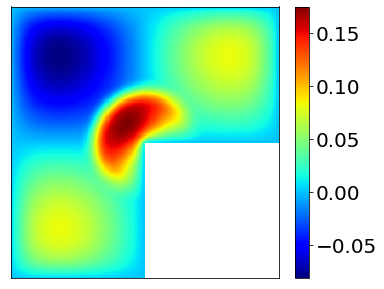

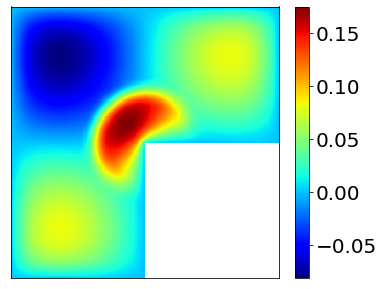

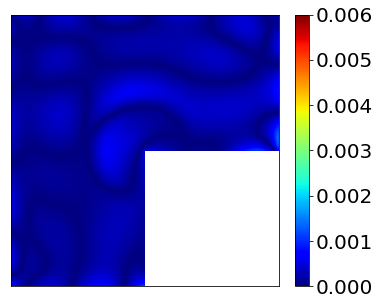

In [6]:
N_v = 800 
N_f = 10000 

X_f_train_np_array, X_v_train_np_array = trainingdata(N_v,N_f)

'Convert to tensor and send to GPU'
X_f_train = torch.from_numpy(X_f_train_np_array).float().to(device)
X_v_train = torch.from_numpy(X_v_train_np_array).float().to(device)
v_train = torch.zeros(X_v_train.shape[0],1).to(device)
X_v_test_tensor = torch.from_numpy(X_v_test).float().to(device)
v = torch.from_numpy(v_true).float().to(device)
u = torch.from_numpy(u_true).float().to(device)
f_hat = torch.zeros(X_f_train.shape[0],1).to(device)

layers = np.array([2,20,20,20,1])

PINN = Sequentialmodel(layers)
       
PINN.to(device)

'Neural Network Summary'

print(PINN)
params = list(PINN.parameters())
sigma = 100
error_vec = 1

start_time = time.time()

optimizer = optim.Adam(PINN.parameters(), lr=1e-3,betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
optimizerl = optim.Adam([PINN.lambdah], lr=1e-3,betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
#optimizer = optim.Adam([DRM.lambdah], lr=0.0001,betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
max_iter = 1000
for i in range(max_iter):
    loss = PINN.loss(X_v_train, v_train, X_f_train, sigma)
    optimizer.zero_grad()     # zeroes the gradient buffers of all parameters
    optimizerl.zero_grad()     # zeroes the gradient buffers of all parameters
    loss.backward()       #backprop
    optimizer.step()
    optimizerl.step()

while sigma<1000 and error_vec>0.001:
    optimizer = torch.optim.LBFGS(PINN.parameters(), lr=0.05,
                              max_iter = 1000, 
                              max_eval = 2500, 
                              tolerance_grad = 1e-06, 
                              tolerance_change = 1e-09, 
                              history_size = 100, 
                              line_search_fn = 'strong_wolfe')

    optimizer.zero_grad()     # zeroes the gradient buffers of all parameters
    optimizer.step(PINN.closure)
    
    error_vec, _ = PINN.test()
    sigma = 1.5 * sigma
    print('error:', error_vec)
    
elapsed = time.time() - start_time                
print('Training time: %.2f' % (elapsed))


''' Model Accuracy ''' 
error_vec, u_pred = PINN.test()

print('sigma:%f' %(sigma/1.5))
print('Test Error: %.5f'  % (error_vec))

# Plotting
xx = np.linspace(-1, 1, 2*n+1)
yy = np.linspace(1, -1, 2*n+1)
Y, X = np.meshgrid(yy, xx)
for i in range(2*n+1):
    for j in range(2*n+1):
        if X[i, j] > 0 and Y[i, j] < 0:
            X[i, j] = float('nan')
            Y[i, j] = float('nan')
for i in range(n+1, 2*n+1):      # to supplement 0 to the 4th quadrant
    for j in range(n+1, 2*n+1):
        u_true = np.insert(u_true, i*(2*n+1)+j, 0)
u_sol = np.reshape(u_true, (2*n+1, 2*n+1), order='F')

# True
fig_1 = plt.figure(1, figsize=(6, 5))
plt.pcolor(X, Y, u_sol, cmap='jet')
h=plt.colorbar()
h.ax.tick_params(labelsize=20)
plt.xticks([])
plt.yticks([])
plt.savefig('true-5',bbox_inches='tight')

# Prediction
fig_2 = plt.figure(2, figsize=(6, 5))
plt.pcolor(X, Y, u_pred, cmap='jet')
h=plt.colorbar()
h.ax.tick_params(labelsize=20)
plt.xticks([])
plt.yticks([])
plt.savefig('pred-5',bbox_inches='tight')

# Error
fig_3 = plt.figure(3, figsize=(6, 5))
plt.pcolor(X, Y, np.abs(u_sol - u_pred), cmap='jet')
h=plt.colorbar()
h.ax.tick_params(labelsize=20)
h.mappable.set_clim(0, 0.006)
plt.xticks([])
plt.yticks([])
plt.savefig('error-5',bbox_inches='tight')
plt.show()